In [1]:
import time
import copy
import random
import numpy as np
import distance
import math
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import optim

from IPython.display import Audio, display
def allDone():
    urL = 'https://www.wavsource.com/snds_2020-10-01_3728627494378403/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))
allDone()

random.seed(666)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda', index=0)

In [2]:
AMINOS = 'XWGSAELQDMPFTRIHVNCY_K'

train_motifs = np.genfromtxt('data_dev/train_motifs.csv',dtype='U')
train_motifxFamMatrix = np.genfromtxt('data_dev/train_motifxFamMatrix.csv',delimiter=',',
                                      dtype=int)
test_motifs = np.genfromtxt('data_dev/test_motifs.csv',dtype='U')
test_motifxFamMatrix = np.genfromtxt('data_dev/test_motifxFamMatrix.csv',delimiter=',',
                                     dtype=int)

fams = np.genfromtxt('data_dev/fams.csv',dtype='U')

all_motifs = np.hstack([train_motifs,test_motifs])
all_motifxFamMatrix = np.vstack([train_motifxFamMatrix,test_motifxFamMatrix])

X_train, X_val = train_test_split(range(len(train_motifs)), test_size=0.1, random_state=666)

print(len(X_train), len(X_val))

5766 641


In [3]:
gram_length = 1

def get_gram_seq(motif,gram_length):
    gram_seq = []
    for i in range(len(motif)):
        gram = motif[i:i+gram_length]
        gram_seq.append(gram)
    return gram_seq

all_grams = []

train_grammed_motifs = []
for motif in train_motifs:
    grammed_motif = get_gram_seq(motif,gram_length)
    train_grammed_motifs.append(grammed_motif)
    all_grams.extend(grammed_motif)
    
test_grammed_motifs = []
for motif in test_motifs:
    grammed_motif = get_gram_seq(motif,gram_length)
    test_grammed_motifs.append(grammed_motif)
    all_grams.extend(grammed_motif)
    
vocab_size = len(set(all_grams))
print("vocab size:",vocab_size)

vocab size: 22


In [4]:
def get_encoded_motifs(grammed_motifs, all_grams):
    gram_counts = Counter(all_grams)
    gram_list = sorted(gram_counts, key=gram_counts.get, reverse=True)
    gram_to_int = {gram:idx+1 for idx, gram in enumerate(gram_list)}  
    encoded_motifs = [[gram_to_int[gram] for gram in motif] for motif in grammed_motifs]
    return encoded_motifs, gram_to_int, gram_list

train_encoded_motifs, gram_to_int, gram_list = get_encoded_motifs(train_grammed_motifs, 
                                                                  all_grams)
test_encoded_motifs, gram_to_int, gram_list = get_encoded_motifs(test_grammed_motifs, 
                                                                 all_grams)

all_encoded_motifs = train_encoded_motifs + test_encoded_motifs

In [36]:
def get_random_motif_and_fam(idc):
    mIdx = random.choice(idc)  
    motif = train_encoded_motifs[mIdx] 
    fIdx = np.where(train_motifxFamMatrix[mIdx]==1)
    theseFams = fams[fIdx]
    return (mIdx,motif,fIdx,theseFams)

def get_batch(idc,batch_size):
    
    batch = []
    switch = 0
    
    while switch < batch_size:
        mIdx_1, motif_1, fIdx_1, fams_1 = get_random_motif_and_fam(idc)
        mIdx_2, motif_2, fIdx_2, fams_2 = get_random_motif_and_fam(idc)
        
        if len(fams_1)==0 and len(fams_2)==0: 
            continue
        
        label = distance.jaccard(set(fams_1),set(fams_2))
        if switch%2 != math.ceil(label):  #round(label): 
            continue
        switch += 1
            
        triplet = [motif_1, motif_2, label]
        batch.append(triplet)

    return batch

In [37]:
from scipy.spatial import distance
class SiameseLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, z1, z2, label, margin=2.0, dist_type='L2'):
        ''' Calculates the pairwise loss given two embeddings and their 0/1 label.
            margin: somewhere between 0.0 and 3.0
            dist_type: manhattan (L1) or euclidean (L2)
        '''
        if dist_type=='L2':
            distance = F.pairwise_distance(z1, z2)
        elif dist_type=='L1':
            distance = torch.sum( torch.abs(z1-z2), axis=1)
        siam_loss = torch.mean((1-label) * torch.pow(distance, 2) +
                                (label) * torch.pow(torch.clamp(margin - distance, 
                                                                min=0.0), 2))
        return siam_loss

In [38]:
def train(model, idc, optimizer, criterion, iters, batch_size, margin, dist_type):
    
    model.train()
    loss_history = 0
    
    for i in range(iters):
            
        batch = get_batch(idc, batch_size)
        motifs_net1 = torch.stack([torch.tensor(x[0]).to(device) for x in batch])
        motifs_net2 = torch.stack([torch.tensor(x[1]).to(device) for x in batch])
        labels = torch.stack([torch.tensor(x[2]).to(device) for x in batch])
        
        optimizer.zero_grad()
        
        embeds_1, embeds_2 = model(motifs_net1, motifs_net2)
        loss = criterion(embeds_1, embeds_2, labels, margin, dist_type)
        
        loss.backward()
        optimizer.step()
                
        loss_history += loss.item()
        
    return loss_history / iters

In [39]:
def evaluate(model, idc, criterion, iters, batch_size, margin, dist_type):
    
    model.eval()
    loss_history = 0

    with torch.no_grad():
        
        for i in range(iters):
            batch = get_batch(idc, batch_size)
            motifs_net1 = torch.stack([torch.tensor(x[0]).to(device) for x in batch])
            motifs_net2 = torch.stack([torch.tensor(x[1]).to(device) for x in batch])
            labels = torch.stack([torch.tensor(x[2]).to(device) for x in batch])
            
            embeds_1, embeds_2 = model(motifs_net1, motifs_net2)
            loss = criterion(embeds_1, embeds_2, labels,margin, dist_type)
                
            loss_history += loss.item()
            
    return loss_history / iters

In [40]:
# from siameseNet_CNN import Model

import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    
### Conv1d(in_channels, out_channels, kernel_size, stride)
        
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=64)   
        
        self.lstm = nn.LSTM(64, 128, bidirectional=True,num_layers=2,
                            batch_first=True,dropout=0.2)
        
#         self.lstm = nn.GRU(64, 128, bidirectional=True,num_layers=2,
#                             batch_first=True,dropout=0.1)
        
        self.fc1 = nn.Linear(128*2*15, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 100)
        
        self.relu = nn.ReLU()
        self.drpt = nn.Dropout(p=0.0)
        
#         self.attend = Attention(128*2)
        
    def forward_once(self, motif): 
#         print(motif.shape)
        
        embedded = self.embedding(motif)
#         print(embedded.shape)

        lstmed, _ = self.lstm(embedded)
    
        flattened = lstmed.reshape(lstmed.shape[0], lstmed.shape[1]*lstmed.shape[2])        
    
#         print(flattened.shape)
        fc1 = self.fc1(flattened)
#         print(fc1.shape)
        fc1 = self.relu(fc1)
        fc1 = self.drpt(fc1)
        
        fc2 = self.fc2(fc1)
#         print(fc2.shape)
        fc2 = self.relu(fc2)
        fc2 = self.drpt(fc2)
        
        fc3 = self.fc3(fc2)
#         print(fc3.shape)
        fc3 = self.relu(fc3)
#         fc3 = self.drpt(fc3)

        out = self.out(fc3)
#         print(out.shape)

        return out
        
    def forward(self, motifs_net1, motifs_net2):
        embed_1 = self.forward_once(motifs_net1)
        embed_2 = self.forward_once(motifs_net2)
        return (embed_1, embed_2)

In [41]:
model = Model() 
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.005 ) 
criterion = SiameseLoss()

bs = 64

# A sub_iter is a single fun through the network
sub_iters = 100
# Loss is calculated per super_iter (collection of sub_iters)
super_iters = 50

my_margin = 1.5
my_dist_type = 'L1'

In [42]:
# print(model)

In [52]:
test_motifs

array(['LCISIDRYVAIVQAV', 'PAPPEPGSPAPGEGP', 'DSGPPDRSPLELHIG', ...,
       'NSLRKRNSMRRNNSM', 'TGTAAAASLATAAGS', 'SNHGLAISPGMKTRI'],
      dtype='<U15')

In [43]:
print("Device:",device,"\n")

train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')
total_time = time.time()

best_super = 0
for i in range(super_iters):
    start = time.time()
    train_loss = train(model, X_train, optimizer, criterion, 
                       iters=sub_iters, batch_size=bs, 
                       margin=my_margin, dist_type=my_dist_type)
    val_loss = evaluate(model, X_val, criterion, 
                        iters=sub_iters, batch_size=bs,
                        margin=my_margin, dist_type=my_dist_type)
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        best_super = i

    print("Time: %5.3f secs, Super iter %d\n* Train loss %5.4f | Val loss: %5.4f" % 
          ( time.time()-start, i+1, train_loss, val_loss ))

final_model = Model().to(device)
final_model.load_state_dict(best_model_wts)

Device: cuda:0 

Time: 7.211 secs, Super iter 1
* Train loss 7.1583 | Val loss: 0.4617
Time: 6.454 secs, Super iter 2
* Train loss 0.4077 | Val loss: 0.3933
Time: 6.401 secs, Super iter 3
* Train loss 0.3882 | Val loss: 0.3747
Time: 6.484 secs, Super iter 4
* Train loss 0.3859 | Val loss: 0.3761
Time: 6.377 secs, Super iter 5
* Train loss 0.3827 | Val loss: 0.3577
Time: 6.328 secs, Super iter 6
* Train loss 0.3862 | Val loss: 0.4293
Time: 6.502 secs, Super iter 7
* Train loss 0.4254 | Val loss: 0.4225
Time: 6.897 secs, Super iter 8
* Train loss 0.4150 | Val loss: 0.3557
Time: 7.010 secs, Super iter 9
* Train loss 0.3845 | Val loss: 0.3720
Time: 6.468 secs, Super iter 10
* Train loss 0.3791 | Val loss: 0.3661
Time: 6.473 secs, Super iter 11
* Train loss 0.3717 | Val loss: 0.3722
Time: 6.390 secs, Super iter 12
* Train loss 0.3532 | Val loss: 0.3510
Time: 6.444 secs, Super iter 13
* Train loss 0.3954 | Val loss: 0.3732
Time: 6.536 secs, Super iter 14
* Train loss 0.3924 | Val loss: 0.367

<All keys matched successfully>

In [44]:
print("--------------------\nLast super iter of learning:",best_super)
print("Total train time: %5.3f mins" % ( (time.time()-total_time)/60 ))
allDone()

--------------------
Last super iter of learning: 42
Total train time: 5.721 mins


In [45]:
run = '19'
torch.save(model.state_dict(), "MODELS_siam/siameseWeights_%s" % run)

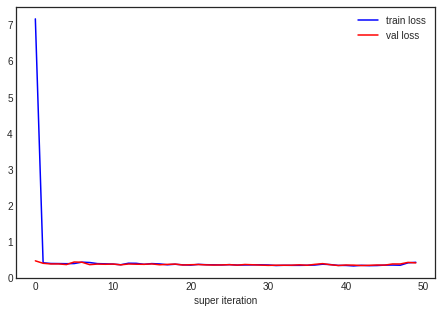

In [46]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(7.5,5))
plt.plot(train_loss_history,label='train loss',c='blue')
plt.plot(val_loss_history,label='val loss',c='red')
plt.xlabel("super iteration")
plt.legend(loc='upper right')
plt.savefig("FIGS_siam/" + run + "_loss")

plt.show()

In [47]:
# final_model = Model().to(device)
# model.load_state_dict(torch.load("MODELS_siam/siameseWeights_06"))

In [48]:
def get_embedding(model, enc_mots):
    model.eval()
    to_embed = torch.tensor(np.array((enc_mots))).to(device)
    embedding = model.forward_once(to_embed)
    return embedding.cpu().detach().numpy()

embedded = get_embedding(model,all_encoded_motifs)   #range(len(motifs)))

In [49]:
df = pd.DataFrame(embedded,dtype=float)
df.to_csv("MODELS_siam/emb_%s_embedding.csv" % (run),header=None,index=None)

In [50]:
import umap.umap_ as umap
umapper = umap.UMAP(
    n_neighbors=20, # changed from 200
    min_dist=0.5, # changed from 0.1
    n_components=2,
    metric='euclidean' )

s = time.time()
pos_umap = umapper.fit_transform(embedded)
# allDone()

print ("secs: %5.3f" % (time.time()-s))

secs: 19.787


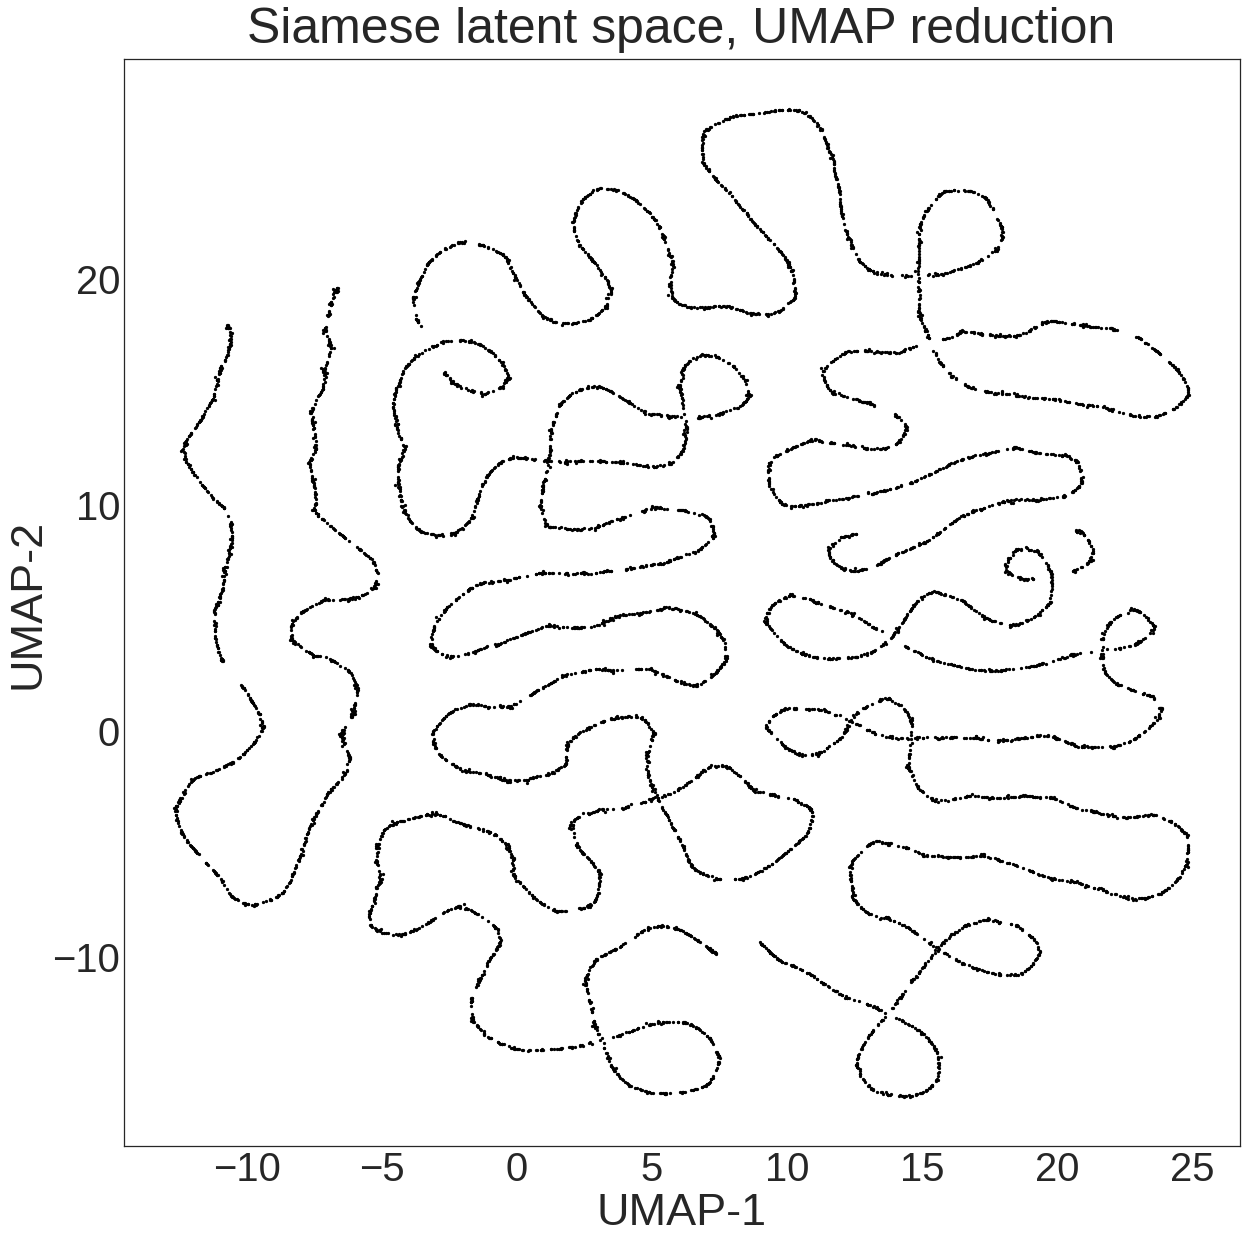

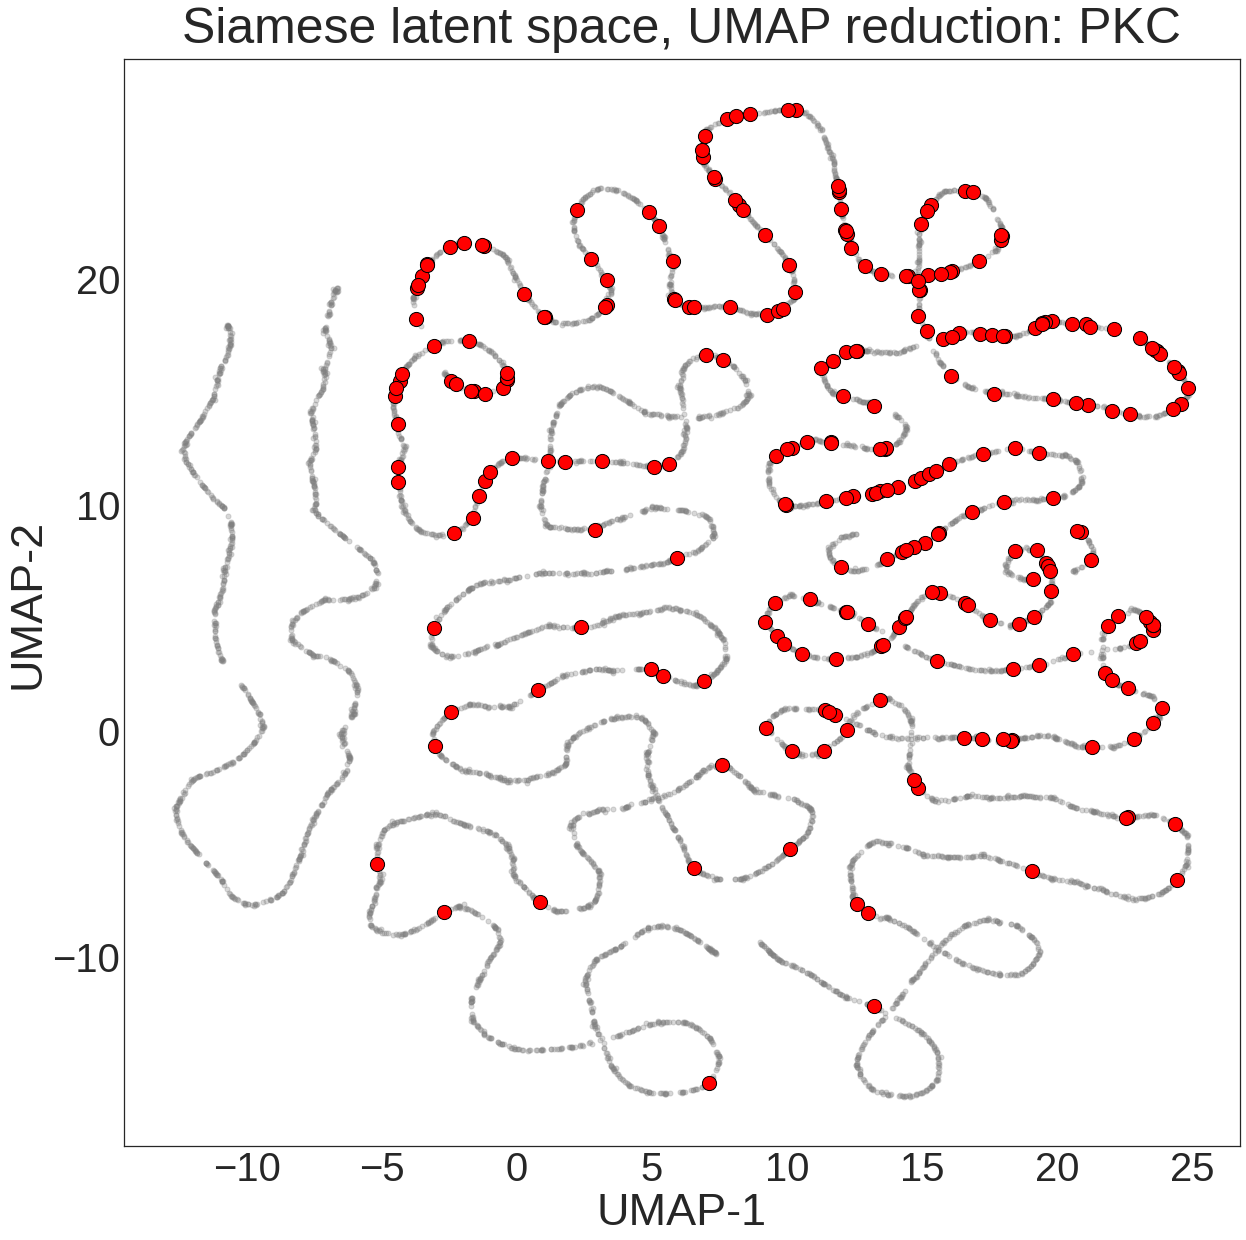

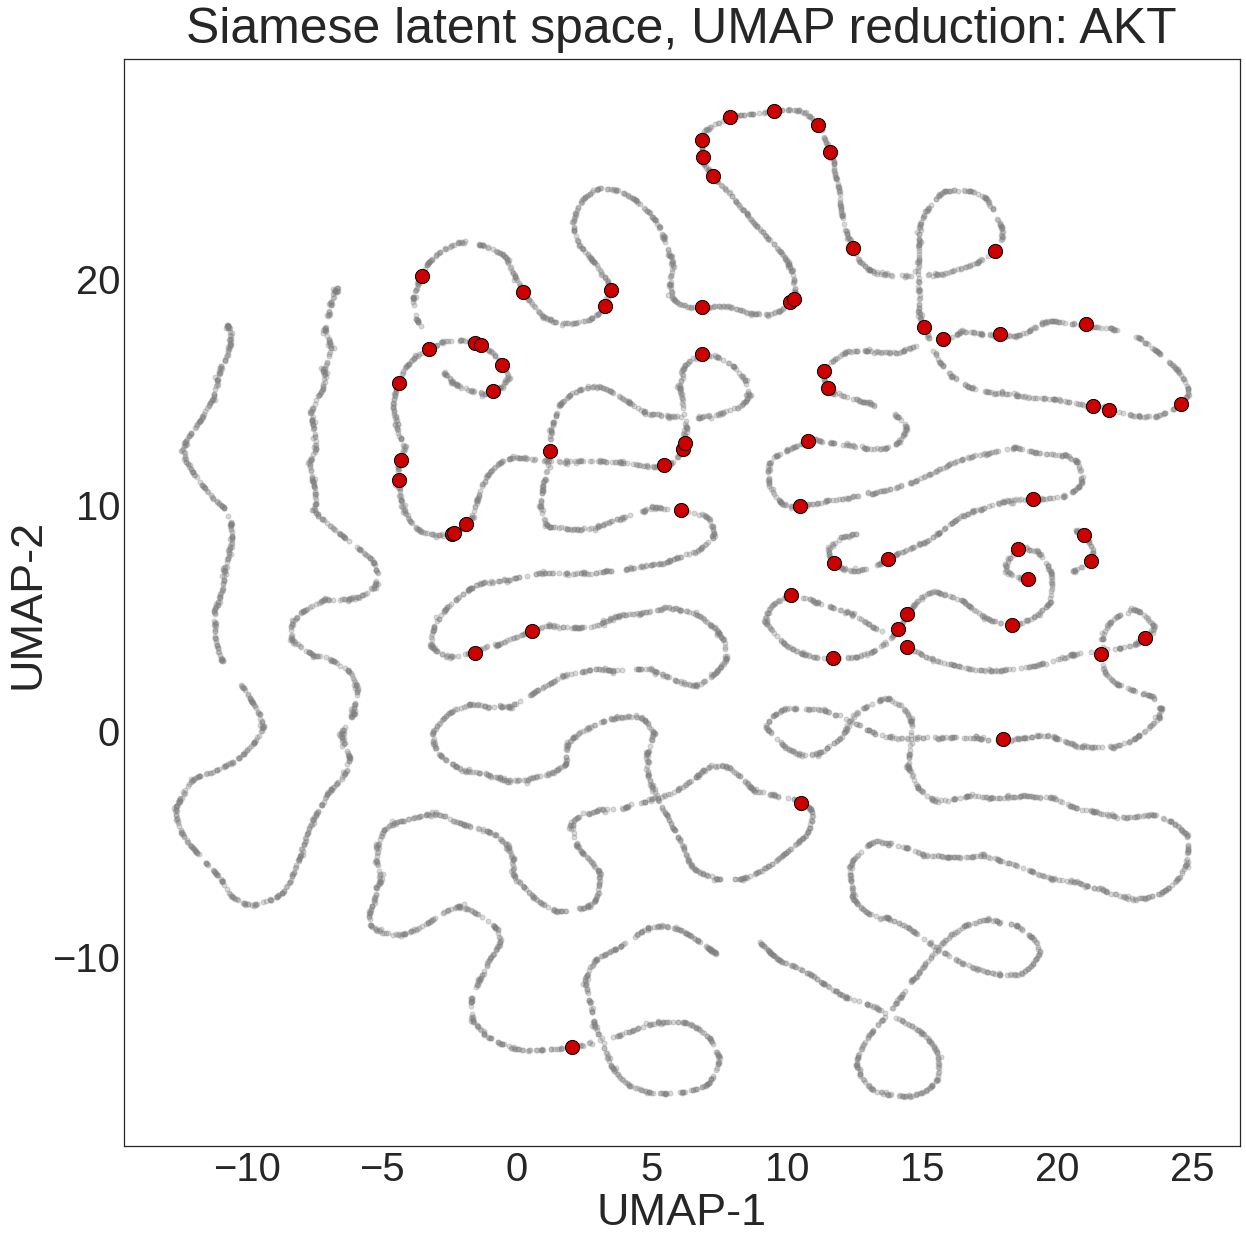

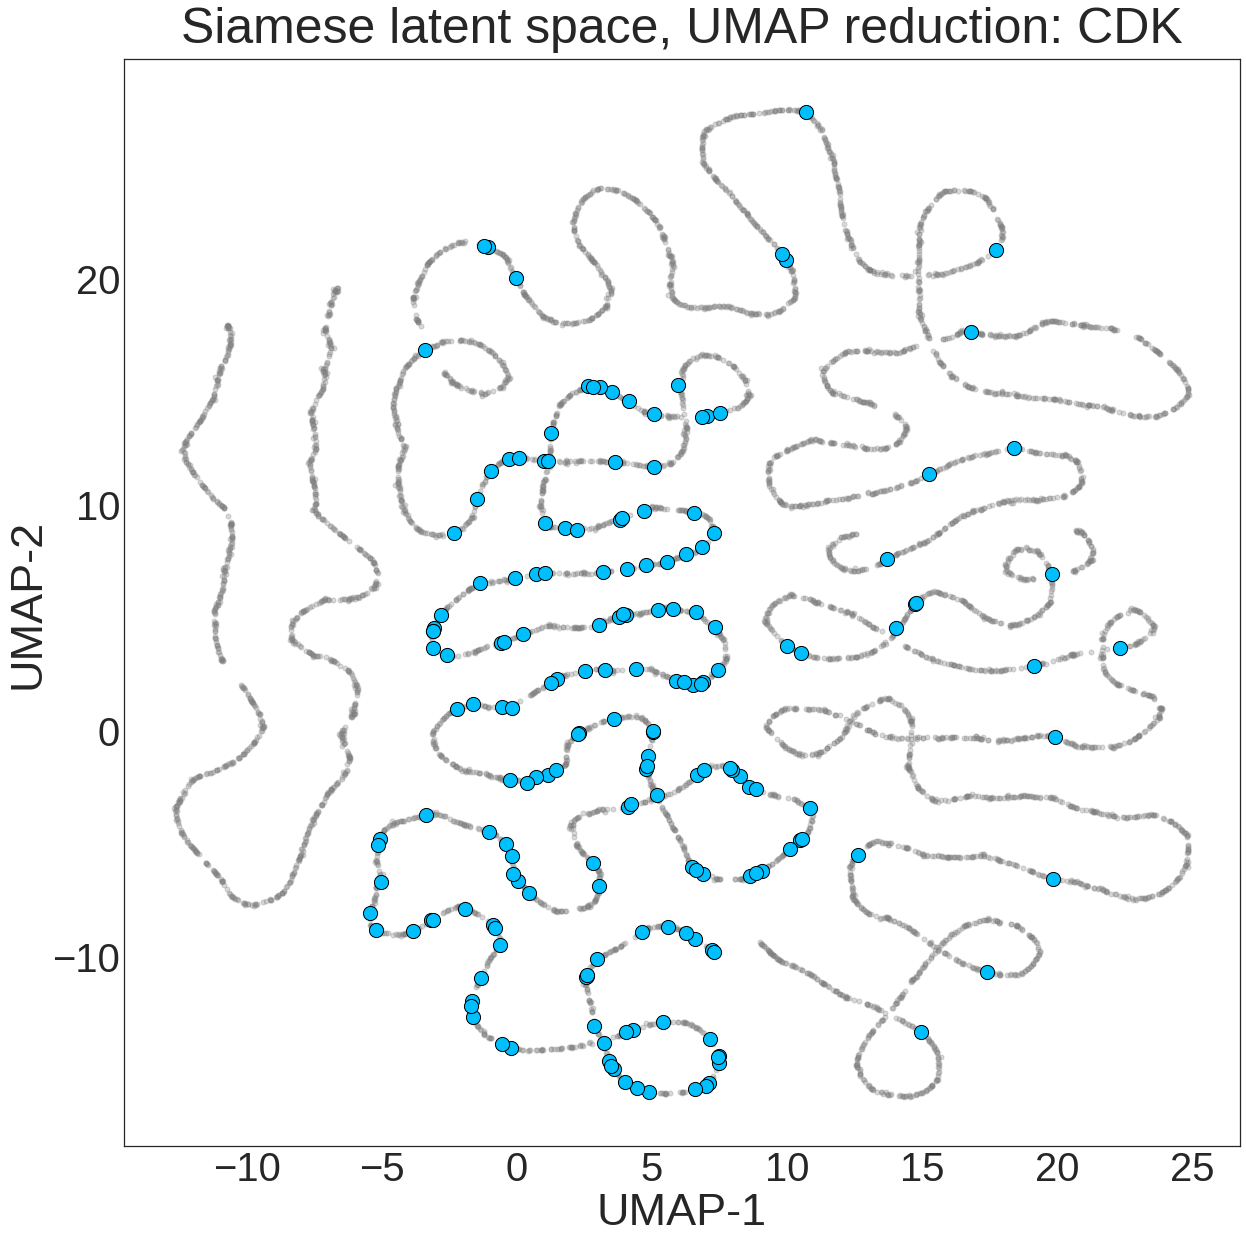

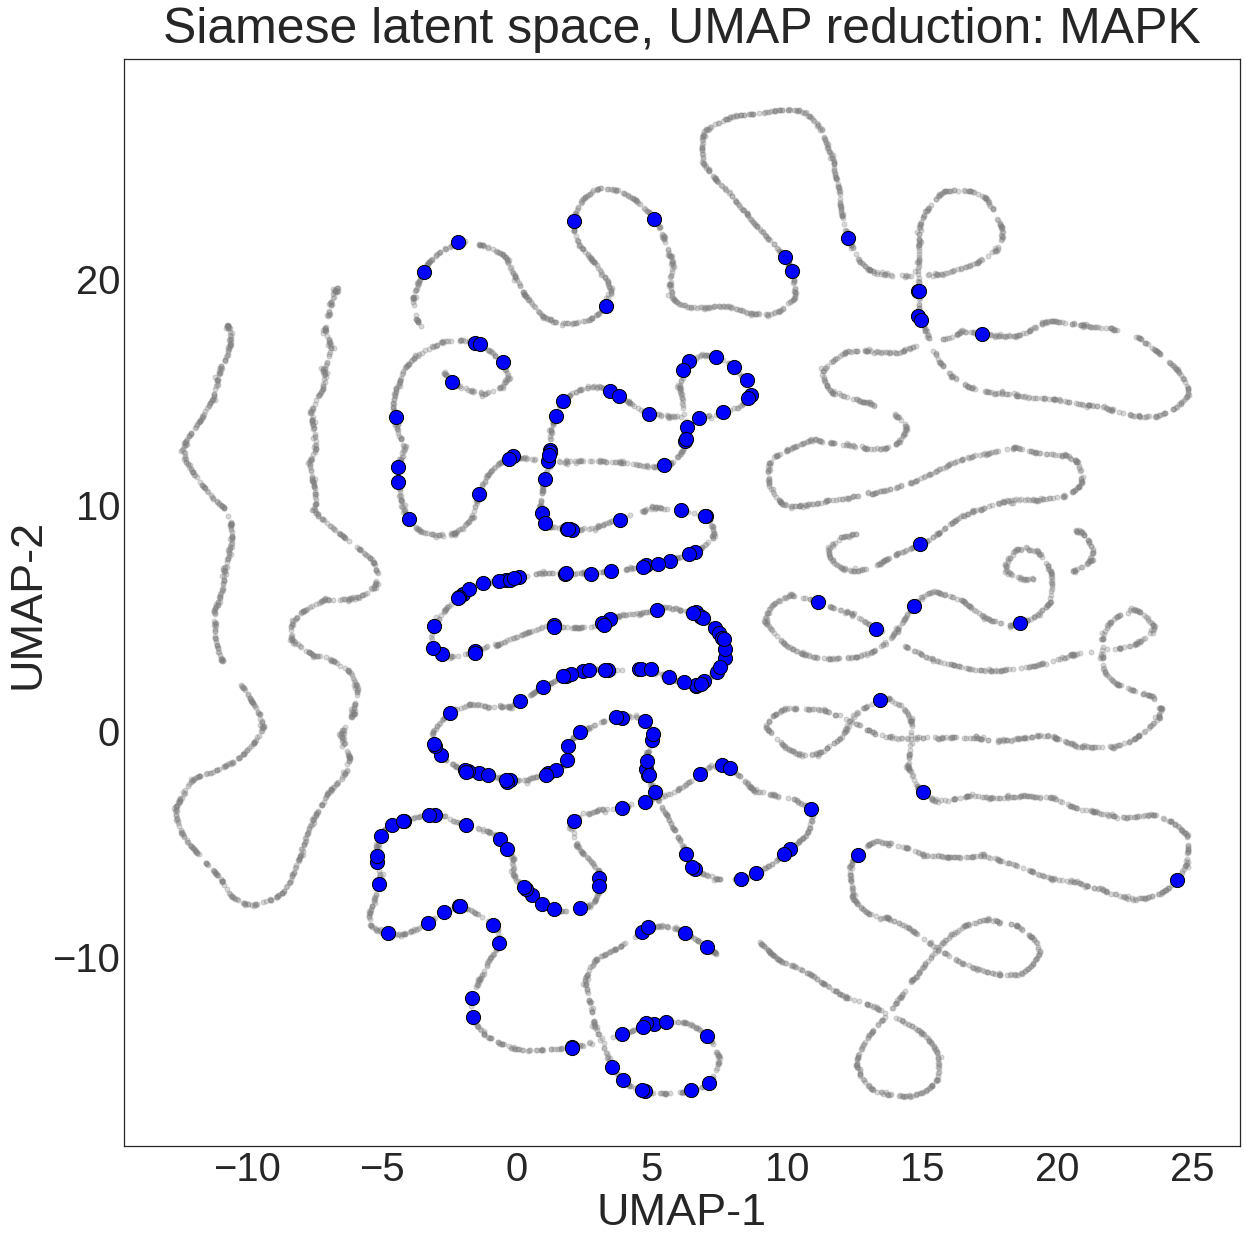

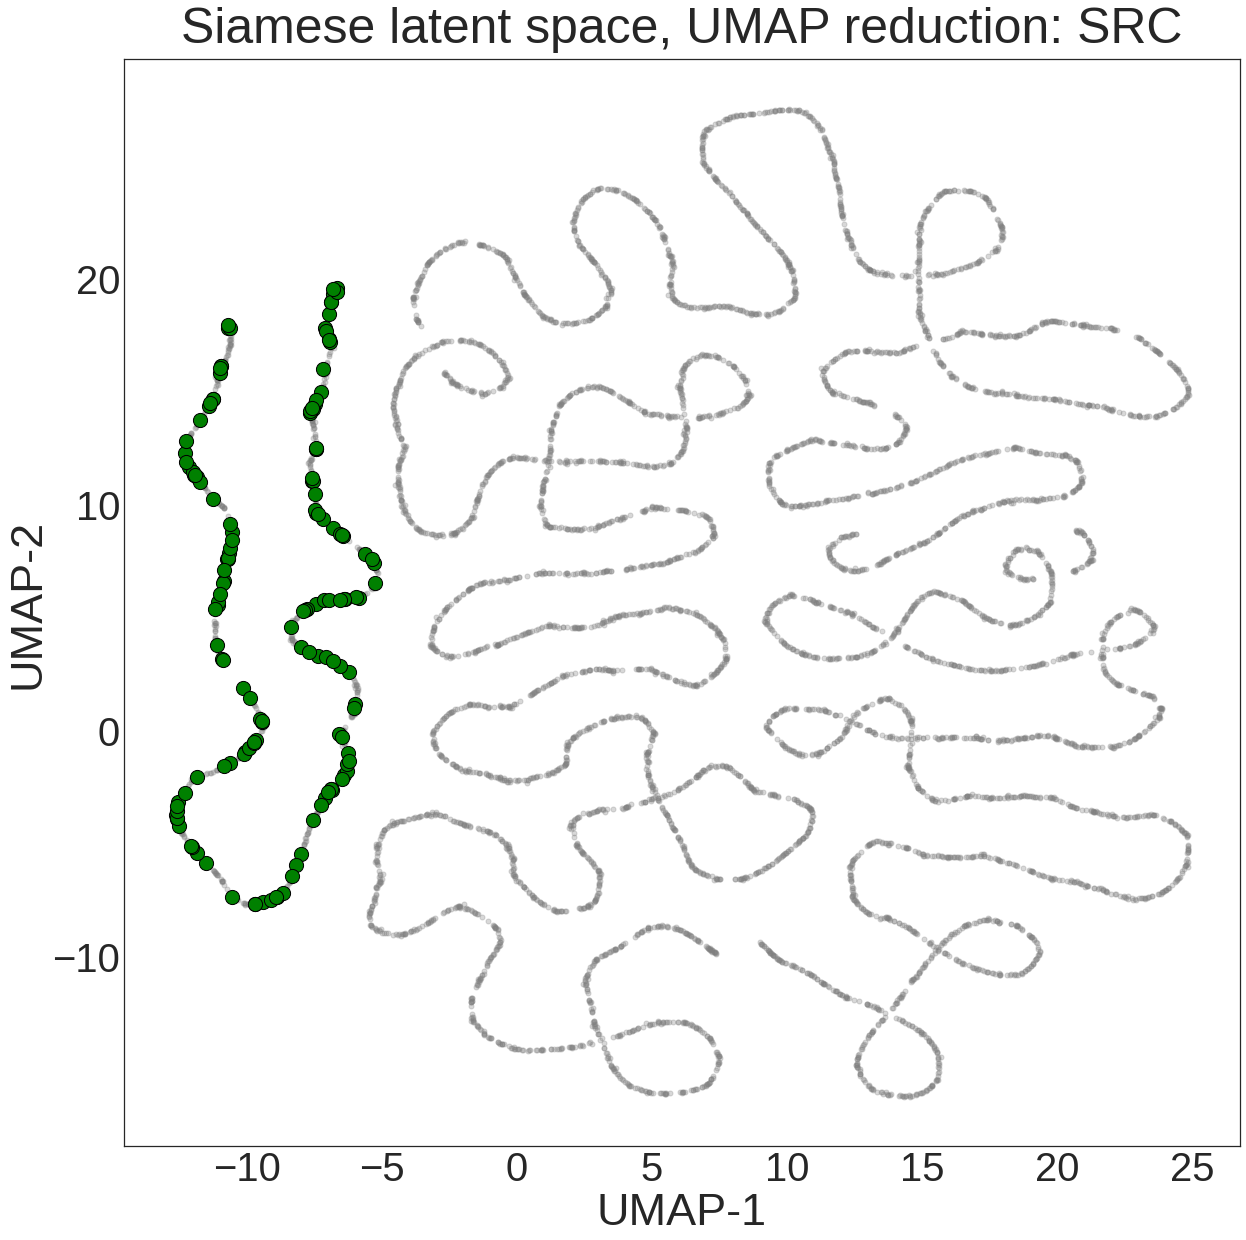

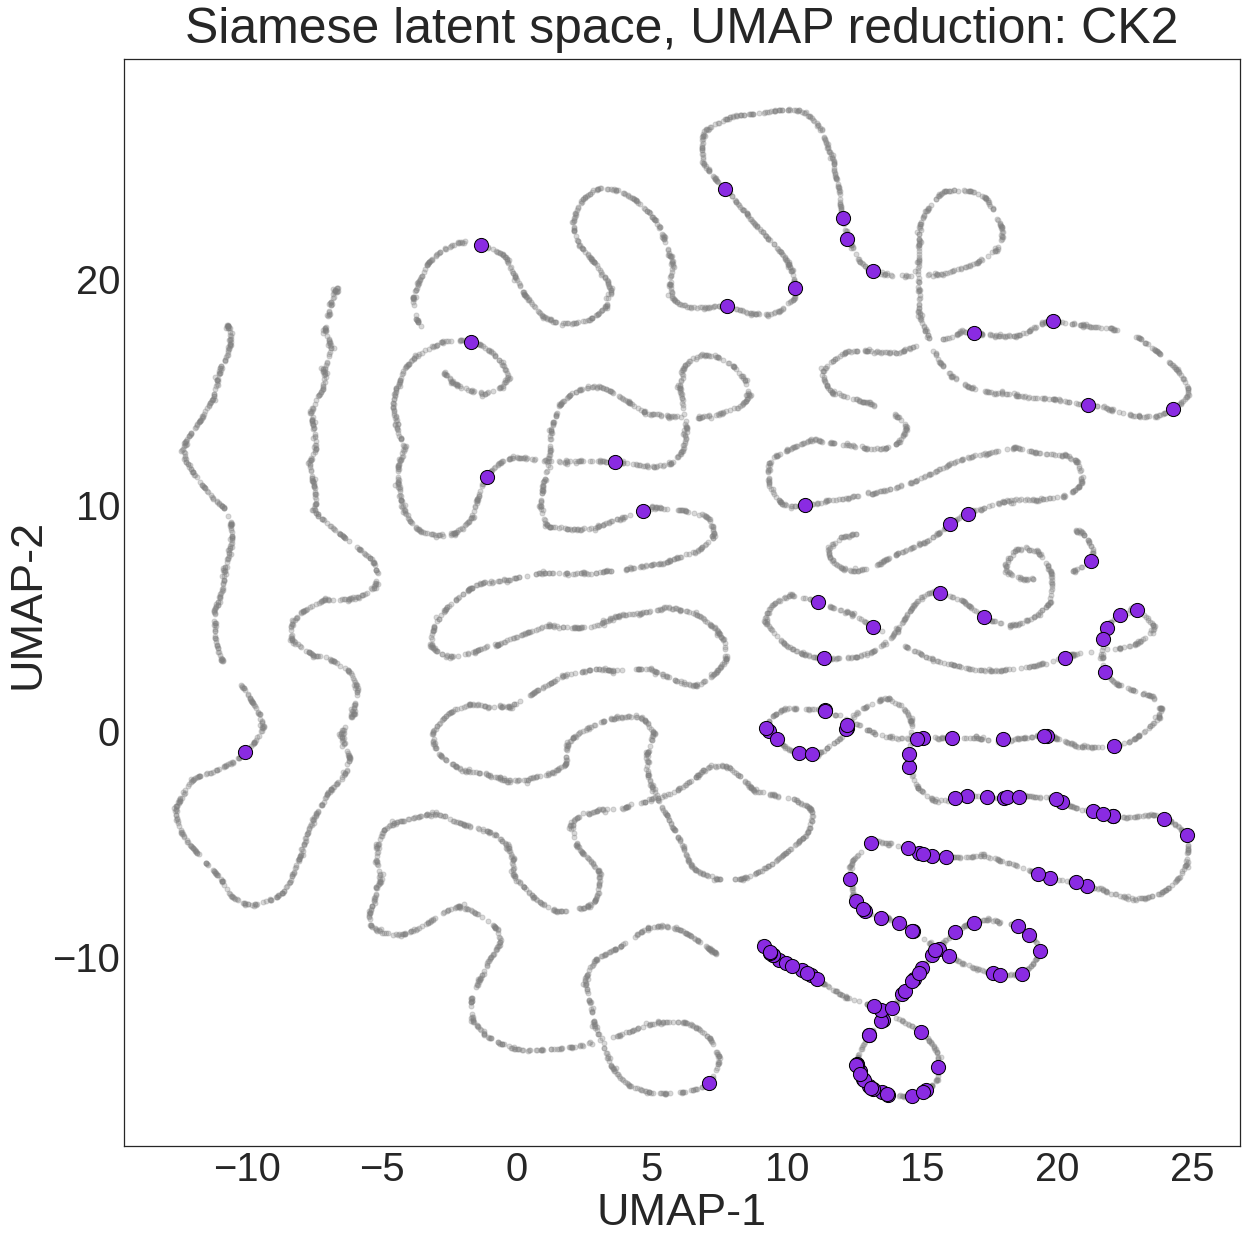

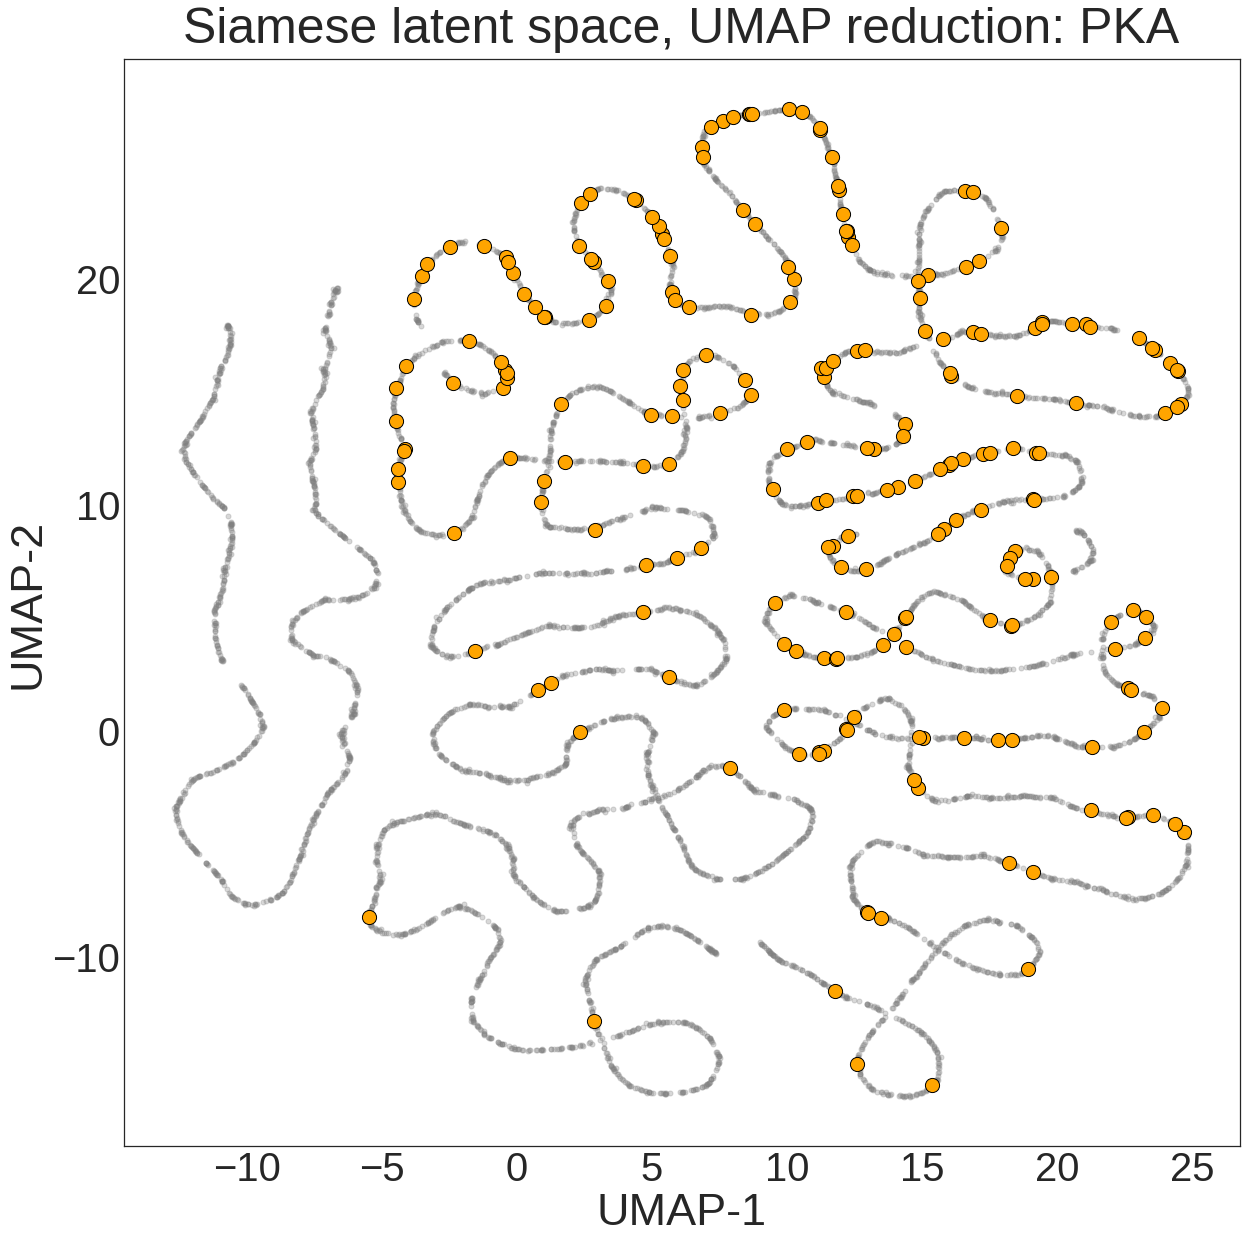

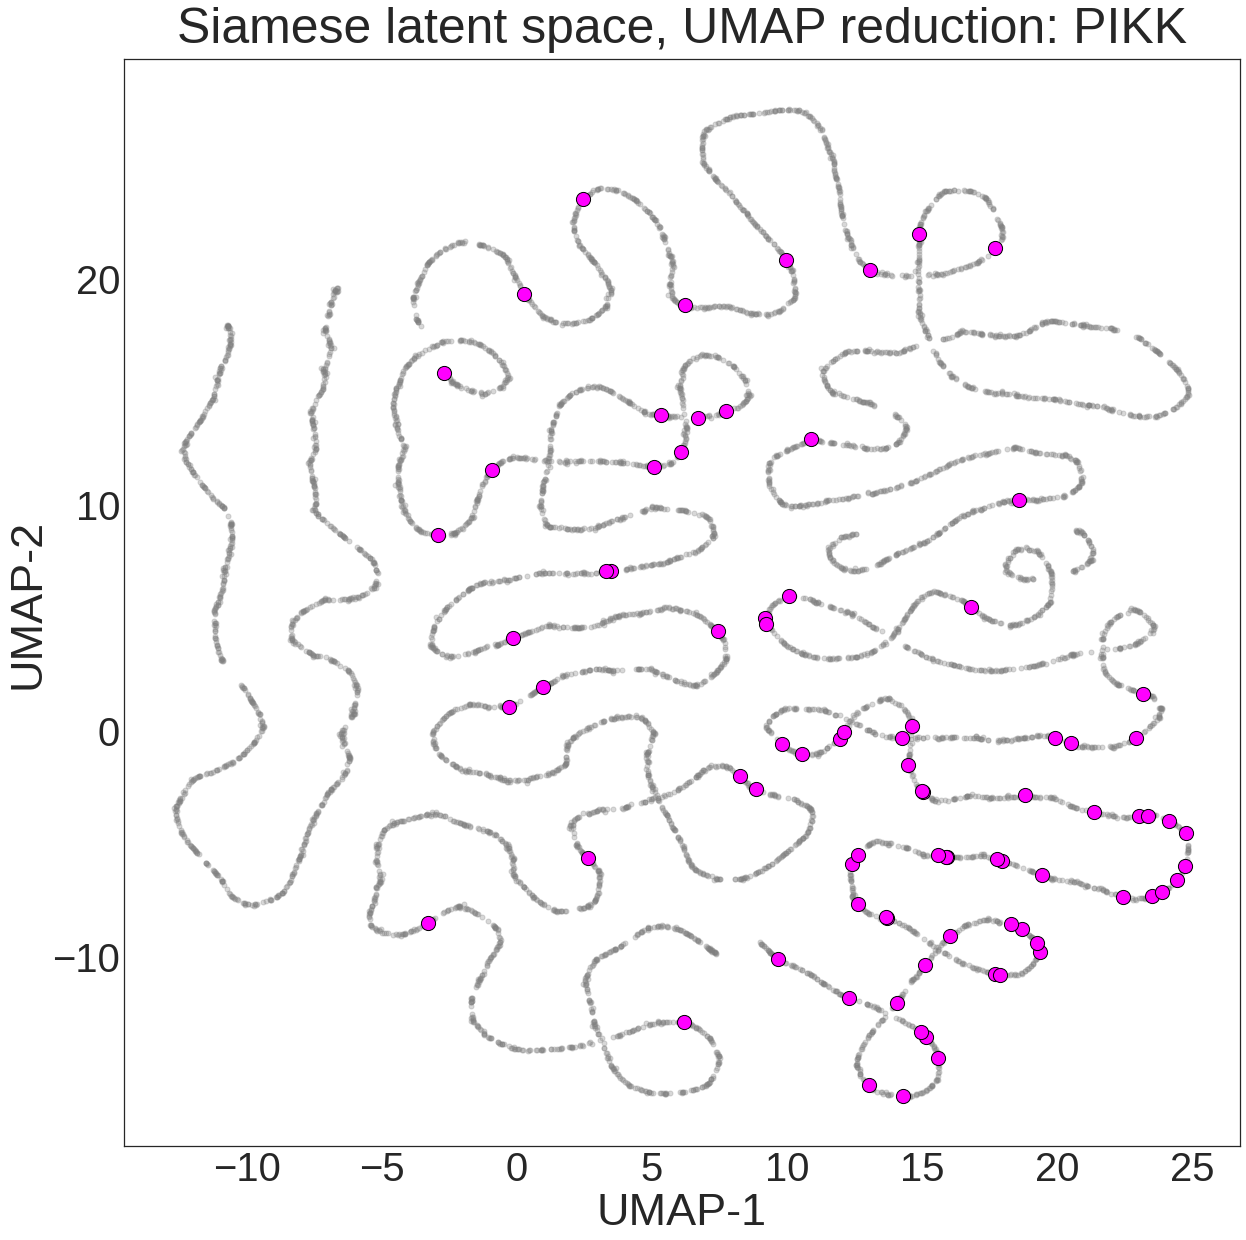

In [51]:
import os
f = 'FIGS_siam/' + run + "/" 
os.mkdir(f)

label_size = 45
title_size = 50
tick_size = 40

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

colors = ['red','#CD0000','deepskyblue','blue','green','blueviolet','orange','magenta','blueviolet','violet','deeppink','crimson','mediumslateblue','brown']

plt.figure(figsize=(20,20))
plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=5,color='black', alpha=1) #alpha=0.25)
plt.title("Siamese latent space, UMAP reduction",fontsize=title_size,y=1.01)
plt.xlabel("UMAP-1",fontsize=label_size)
plt.ylabel("UMAP-2",fontsize=label_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig( f + "noHighlights")
plt.show()

pop_fams = ['PKC', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKA', 'PIKK']
# pop_fams = ['CAMK-UNIQUE', 'DYRK', 'CAMKL', 'STE20', 'PKC', 'AKT', 'CDK', 'MAPK', 'SRC', 'CK2', 'PKA', 'PIKK']


i = -1
for _,fam in enumerate(pop_fams):
    
    i+=1
    fIdx = np.where(fams==fam)[0][0]
    plt.figure(figsize=(20,20))
    plt.title(("Siamese latent space, UMAP reduction: %s" % fam),fontsize=title_size,y=1.01)
    plt.xticks(fontsize=tick_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
    plt.yticks(fontsize=tick_size)
    plt.xlabel("UMAP-1",fontsize=label_size)
    plt.ylabel("UMAP-2",fontsize=label_size)
    plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=25,color='grey',alpha=0.30)
    for mIdx, (x, y) in enumerate(zip(pos_umap[:, 0], pos_umap[:, 1])):
        if all_motifs[mIdx] not in test_motifs:
            continue
        elif all_motifxFamMatrix[mIdx][fIdx]==1:
            plt.scatter(x,y,marker='o',s=200,c=colors[i],alpha=1.0,edgecolors='black')          
    plt.savefig((f+"%s" % fam))
    plt.show()

In [ ]:
# class Attention(nn.Module):
#     def __init__(self, feature_dim=22, step_dim=15, bias=True, **kwargs):
#         super(Attention, self).__init__(**kwargs)
        
#         self.supports_masking = True

#         self.bias = bias
#         self.feature_dim = feature_dim
#         self.step_dim = step_dim
#         self.features_dim = 0
        
#         weight = torch.zeros(feature_dim, 1)
#         nn.init.kaiming_uniform_(weight)
#         self.weight = nn.Parameter(weight)
        
#         if bias:
#             self.b = nn.Parameter(torch.zeros(step_dim))
        
#     def forward(self, x, mask=None):
#         feature_dim = self.feature_dim 
#         step_dim = self.step_dim
        
#         print(x.shape)

#         eij = torch.mm(
#             x.contiguous().view(-1, feature_dim), 
#             self.weight
#         ).view(-1, step_dim)
        
#         if self.bias:
#             eij = eij + self.b
            
#         eij = torch.tanh(eij)
#         a = torch.exp(eij)
        
#         if mask is not None:
#             a = a * mask

#         a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

#         weighted_input = x * torch.unsqueeze(a, -1)
#         return torch.sum(weighted_input, 1)